<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 28.86 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Get data

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a5a47ebb010>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 79.2MB/s]


In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [9]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [10]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1033 | train_acc: 0.3789 | test_loss: 0.8906 | test_acc: 0.5701
Epoch: 2 | train_loss: 0.9392 | train_acc: 0.6445 | test_loss: 0.8079 | test_acc: 0.7027
Epoch: 3 | train_loss: 0.7611 | train_acc: 0.8945 | test_loss: 0.6431 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7602 | train_acc: 0.6992 | test_loss: 0.5840 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6309 | train_acc: 0.8867 | test_loss: 0.6012 | test_acc: 0.9072
[INFO] Total training time: 177.820 seconds


### Make predictions on the entire test dataset with the model

In [12]:
from tqdm.auto import tqdm
import torch

def make_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    with torch.inference_mode():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            probs = torch.softmax(logits, dim=1)
            labels = torch.argmax(probs, dim=1)
            all_preds.append(labels)
    return torch.cat(all_preds).cpu()
pred = make_predictions(model_0, test_dataloader, "cpu")
pred

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [13]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 29.0 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [14]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


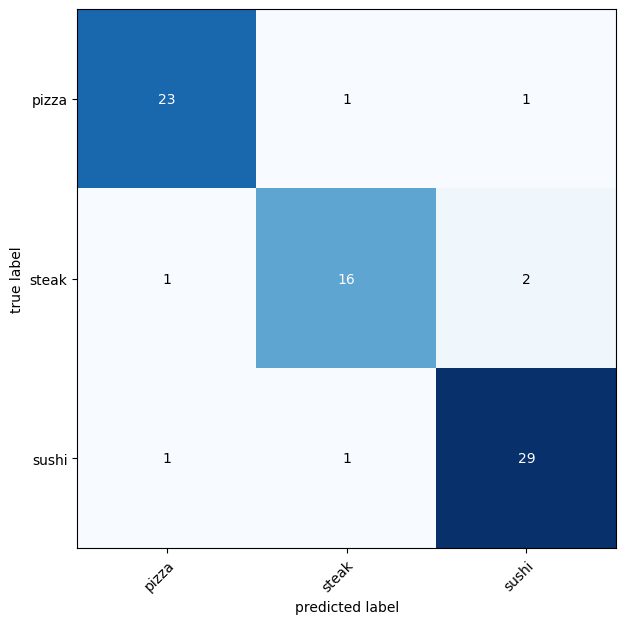

In [20]:
from torchmetrics.classification import MulticlassConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
def plot_confusion_matrix_from_predictions(preds, targets, class_names):
    confmat = MulticlassConfusionMatrix(num_classes=len(class_names))
    confmat_tensor = confmat(preds, targets)

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),  # Convert to NumPy array for plotting
        class_names=class_names,
        figsize=(10, 7)
    )
    plt.show()
true_answer= torch.cat([y for X, y in test_dataloader])
plot_confusion_matrix_from_predictions(pred, true_answer, class_names)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [22]:
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
import torch

def get_test_data_paths_and_labels(test_dir):
    test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
    test_labels = [path.parent.stem for path in test_data_paths]
    return test_data_paths, test_labels

def pred_and_store(test_paths, model, transform, class_names, device):
    test_pred_list = []
    model.eval()
    with torch.inference_mode():
        for path in tqdm(test_paths):
            pred_dict = {
                "image_path": path,
                "class_name": path.parent.stem
            }

            img = Image.open(path)
            transformed_image = transform(img).unsqueeze(0).to(device)

            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            pred_dict["pred_prob"] = pred_prob.max().cpu().item()
            pred_dict["pred_class"] = pred_class
            pred_dict["correct"] = pred_dict["class_name"] == pred_class

            test_pred_list.append(pred_dict)

    return test_pred_list


test_dir = "data/pizza_steak_sushi/test"
test_data_paths, test_labels = get_test_data_paths_and_labels(test_dir)

test_pred_dicts = pred_and_store(
        test_paths=test_data_paths,
        model=model_0,
        transform=simple_transform,
        class_names=class_names,
        device=device
    )

print(test_pred_dicts[:5])


  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'), 'class_name': 'pizza', 'pred_prob': 0.7770631313323975, 'pred_class': 'pizza', 'correct': True}, {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'), 'class_name': 'pizza', 'pred_prob': 0.5648263096809387, 'pred_class': 'pizza', 'correct': True}, {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'), 'class_name': 'pizza', 'pred_prob': 0.7438591122627258, 'pred_class': 'pizza', 'correct': True}, {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg'), 'class_name': 'pizza', 'pred_prob': 0.4912768304347992, 'pred_class': 'pizza', 'correct': True}, {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/971934.jpg'), 'class_name': 'pizza', 'pred_prob': 0.4519812762737274, 'pred_class': 'pizza', 'correct': True}]


In [23]:
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
34,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.504828,steak,False
70,data/pizza_steak_sushi/test/steak/1285886.jpg,steak,0.424436,sushi,False
13,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.420366,steak,False
43,data/pizza_steak_sushi/test/sushi/175783.jpg,sushi,0.390239,pizza,False
69,data/pizza_steak_sushi/test/steak/1627703.jpg,steak,0.388568,sushi,False


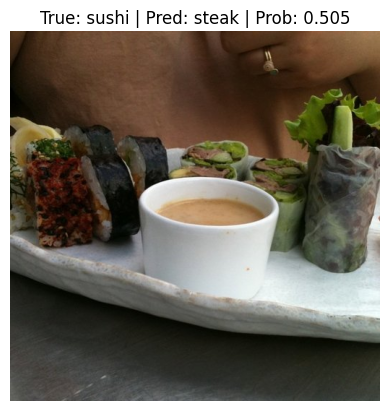

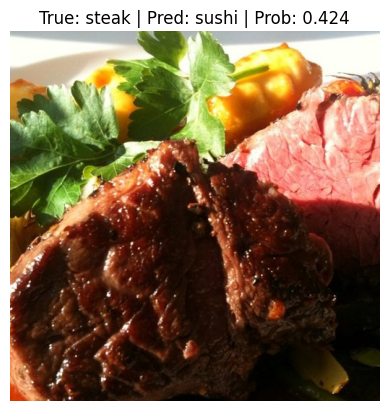

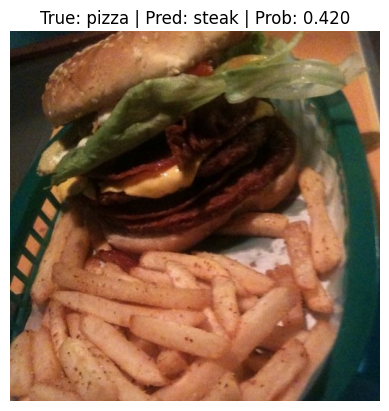

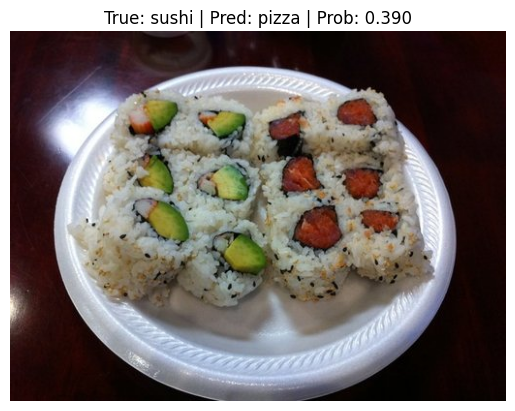

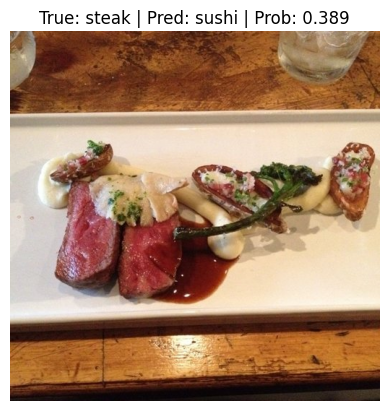

In [25]:
def plot_most_wrong_images(most_wrong_df):
    for _, row in most_wrong_df.iterrows():
        image_path = row[0]
        true_label = row[1]
        pred_prob = row[2]
        pred_class = row[3]

        img = torchvision.io.read_image(str(image_path))  # get image as tensor
        plt.figure()
        plt.imshow(img.permute(1, 2, 0))  # matplotlib likes images in [height, width, color_channels]
        plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
        plt.axis(False)

plot_most_wrong_images(top_5_most_wrong)


## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

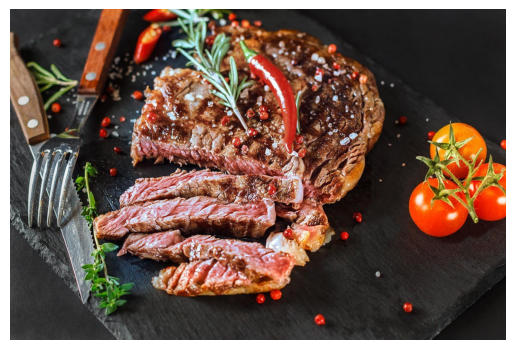

In [32]:
# TODO: Get an image of pizza/steak/sushi
img_1 = torchvision.io.read_image("test1.jpg")
plt.imshow(img_1.permute(1, 2, 0))
plt.axis(False);


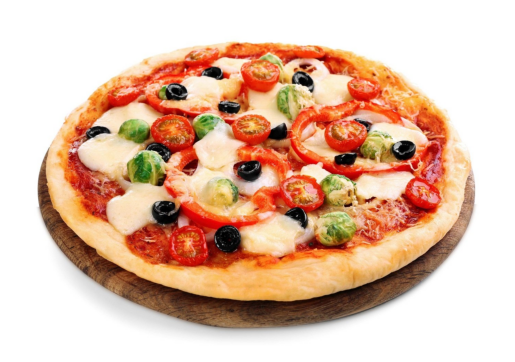

In [33]:
img_2 = torchvision.io.read_image("test2.jpg")
plt.imshow(img_2.permute(1, 2, 0))
plt.axis(False);

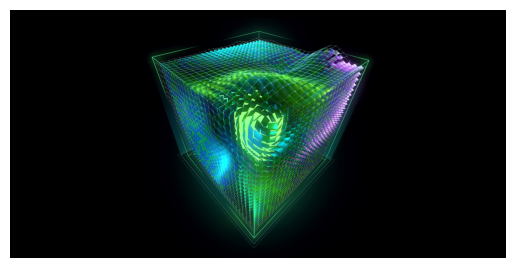

In [34]:
img_3 = torchvision.io.read_image("test3.jpg")
plt.imshow(img_3.permute(1, 2, 0))
plt.axis(False);

In [35]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def pred_and_plot(image_path, model, transform, class_names, device):
    # Open image
    image = Image.open(image_path)

    # Transform image
    transformed_image = transform(image).unsqueeze(0).to(device)

    # Predict on image
    model.eval()
    with torch.inference_mode():
        pred_logit = model(transformed_image)
        pred_prob = torch.softmax(pred_logit, dim=1)
        pred_label = torch.argmax(pred_prob, dim=1).cpu().item()

    # Plot image and prediction
    plt.figure()
    plt.imshow(image)
    plt.title(f"Pred: {class_names[pred_label]}")
    plt.axis(False)
    plt.show()


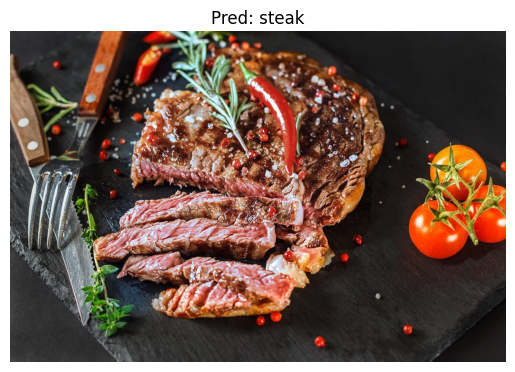

In [36]:
pred_and_plot(image_path="test1.jpg",model=model_0,transform=simple_transform,class_names=class_names,device=device)

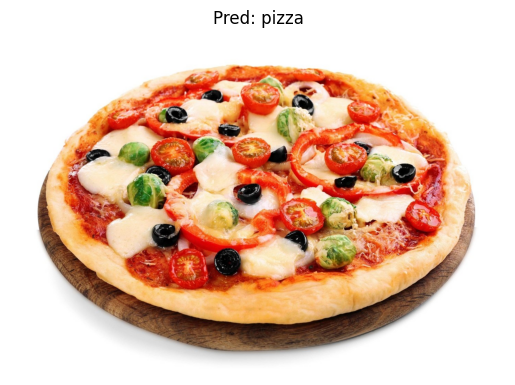

In [37]:
pred_and_plot(image_path="test2.jpg",model=model_0,transform=simple_transform,class_names=class_names,device=device)

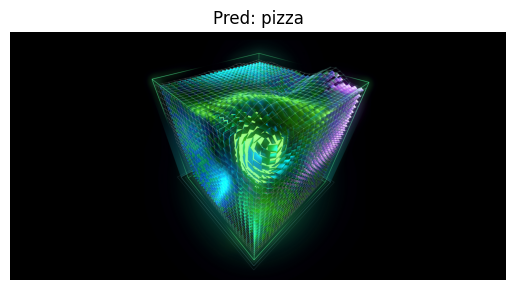

In [38]:
pred_and_plot(image_path="test3.jpg",model=model_0,transform=simple_transform,class_names=class_names,device=device)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [39]:
# TODO: Recreate a new model
import torchvision
from torch import nn
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze the base layers
for param in model_1.features.parameters():
  param.requires_grad = False

# Change the classification head
torch.manual_seed(42)
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
import torchvision
import torch
from torch import nn
from timeit import default_timer as timer

def setup_model_and_train(class_names, train_dataloader, test_dataloader, device, epochs):
    # Recreate a new model
    model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

    # Freeze the base layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Change the classification head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
    ).to(device)

    # Set random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Start the timer
    start_time = timer()

    # Create loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    model_results = engine.train(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=epochs,
        device=device
    )
    end_time = timer()
    print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

    return model, model_results


model_1, model_1_results = setup_model_and_train(class_names=class_names,train_dataloader=train_dataloader,test_dataloader=test_dataloader,device=device, epochs = 10)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0577 | train_acc: 0.4102 | test_loss: 0.8372 | test_acc: 0.6818
Epoch: 2 | train_loss: 0.9024 | train_acc: 0.7070 | test_loss: 0.7535 | test_acc: 0.8059
Epoch: 3 | train_loss: 0.7330 | train_acc: 0.8945 | test_loss: 0.6009 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7466 | train_acc: 0.7188 | test_loss: 0.5498 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6022 | train_acc: 0.8867 | test_loss: 0.5683 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.5711 | train_acc: 0.8008 | test_loss: 0.5217 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.5717 | train_acc: 0.7891 | test_loss: 0.5439 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.4887 | train_acc: 0.7969 | test_loss: 0.4711 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4617 | train_acc: 0.9336 | test_loss: 0.4805 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.5084 | train_acc: 0.7969 | test_loss: 0.5082 | test_acc: 0.9176
[INFO] Total training time: 404.818 seconds


## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [42]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [43]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [44]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a59496f63e0>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [45]:
model_2, model_2_results = setup_model_and_train(class_names=class_names,train_dataloader=train_dataloader,test_dataloader=test_dataloader,device=device, epochs = 25)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0645 | train_acc: 0.4180 | test_loss: 0.8716 | test_acc: 0.6222
Epoch: 2 | train_loss: 0.8946 | train_acc: 0.6758 | test_loss: 0.7772 | test_acc: 0.7131
Epoch: 3 | train_loss: 0.7297 | train_acc: 0.8906 | test_loss: 0.6213 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7354 | train_acc: 0.7305 | test_loss: 0.5712 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.5933 | train_acc: 0.9102 | test_loss: 0.5900 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.5861 | train_acc: 0.7852 | test_loss: 0.5434 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5547 | train_acc: 0.7969 | test_loss: 0.5635 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.4984 | train_acc: 0.8008 | test_loss: 0.4843 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4692 | train_acc: 0.9375 | test_loss: 0.4894 | test_acc: 0.8968
Epoch: 10 | train_loss: 0.5196 | train_acc: 0.8008 | test_loss: 0.5200 | test_acc: 0.8864
Epoch: 11 | train_loss: 0.4433 | train_acc: 0.8242 | test_loss: 0.4915 | test_acc: 0.9176
Epoch: 12 | train_l

### Train a model with 20% of the data

In [46]:
model_3, model_3_results = setup_model_and_train(class_names=class_names,train_dataloader=train_dataloader_20_percent,test_dataloader=test_dataloader_20_percent,device=device, epochs = 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9428 | train_acc: 0.6479 | test_loss: 0.6553 | test_acc: 0.8722
Epoch: 2 | train_loss: 0.6833 | train_acc: 0.8271 | test_loss: 0.5320 | test_acc: 0.9068
Epoch: 3 | train_loss: 0.5406 | train_acc: 0.8542 | test_loss: 0.4442 | test_acc: 0.9097
Epoch: 4 | train_loss: 0.4506 | train_acc: 0.9000 | test_loss: 0.4025 | test_acc: 0.9068
Epoch: 5 | train_loss: 0.4483 | train_acc: 0.8729 | test_loss: 0.3681 | test_acc: 0.9159
[INFO] Total training time: 354.200 seconds


In [47]:
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.9071969696969697, 0.5839809576670328)

In [48]:
# Check results with 20% of data for 5 epochs
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.9384469696969697, 0.3186323543389638)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [52]:
effnet_b2_transform = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [53]:
import torchvision
import torch
from torch import nn
from timeit import default_timer as timer

def setup_and_train_effnet_b2(train_dir, test_dir, class_names, device):
    # Import the data
    train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(
        train_dir=train_dir,
        test_dir=test_dir,
        transform=effnet_b2_transform,
        batch_size=32
    )

    # Create a effnet_b2 new model
    model = torchvision.models.efficientnet_b2(pretrained=True).to(device)

    # Freeze the base layers
    for param in model.parameters():
        param.requires_grad = False

    # Change the classifier head (to suit our problem)
    torch.manual_seed(42)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
    ).to(device)

    # Set random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Start the timer
    start_time = timer()

    # Create loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    model_results = engine.train(
        model=model,
        train_dataloader=train_dataloader_effnet_b2,
        test_dataloader=test_dataloader_effnet_b2,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=5,
        device=device
    )

    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

    return model, model_results

    # Assuming `train_dir`, `test_dir`, `effnet_b2_transform`, `class_names`, and `device` are defined elsewhere
model_3, model_3_results = setup_and_train_effnet_b2(
        train_dir=train_dir,
        test_dir=test_dir,
        class_names=class_names,
        device=device
    )


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 65.9MB/s]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1039 | train_acc: 0.3477 | test_loss: 0.9379 | test_acc: 0.6307
Epoch: 2 | train_loss: 0.9083 | train_acc: 0.5898 | test_loss: 0.8722 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.7391 | train_acc: 0.8633 | test_loss: 0.7607 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.7964 | train_acc: 0.7227 | test_loss: 0.7237 | test_acc: 0.7955
Epoch: 5 | train_loss: 0.6825 | train_acc: 0.7695 | test_loss: 0.6749 | test_acc: 0.9280
[INFO] Total training time: 471.868 seconds


In [54]:
max(model_3_results["test_acc"]), min(model_3_results["test_loss"])

(0.9280303030303031, 0.6749020020167033)